Need files "exp3a_data.csv", "exp3a_data_summary.csv", "exp3_effective_area_change.csv"

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as stats
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch

# Functional Forms

(0.0, 1.0)

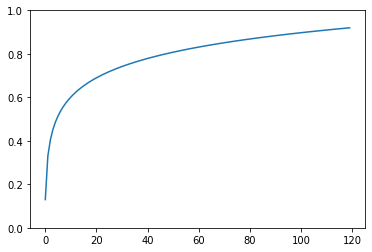

In [5]:
def func_log(x, a, b, tol=1e-8): 
  # Log function, no complexity term
  return (0.12983630952380953 + a) * np.log( np.exp(1) + b * np.array(x) ) - a # when x=0, y=human_nochange_average

# Visualize the function with some random parameter values
npoints = 120
x = np.arange(0, npoints, 1)
y = func_log(x, 0.0000000001, 10.001565009220208)
plt.plot(x, y)
plt.ylim(0,1)

(0.0, 1.0)

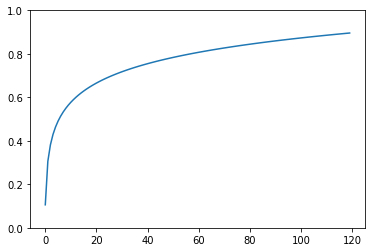

In [6]:
def func_complexity_log(x, a, b, k, tol=1e-8):
  # Log functional form, with linear complexity term
  input = x[: len(x)//2] # the first half of x stores real x values
  input[input < tol] = 0 # reset values too small
  comp = x[len(x)//2 :] # the second half of x stores complexity
  return (0.12983630952380953 + a) * np.log( np.exp(1) + b * np.array(input) ) - a - k * np.array(comp) # when x=0, y=human_nochange_average - k*comp

# Visualize the function with some random parameter values
npoints = 120
x = np.arange(0, npoints, 1) # arbitrary input values
x = np.concatenate((x, np.ones(npoints)*24)) # arbitrary complexity
y = func_complexity_log(x, 0.0000000001, 10.001565009220208, 0.001)
plt.plot(x[:len(x)//2], y)
plt.ylim(0,1)

(0.0, 1.0)

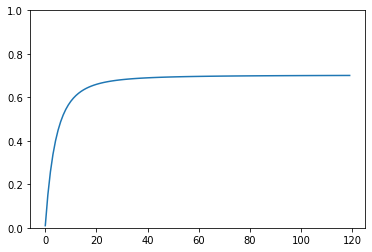

In [7]:
def func_complexity_exp(x, a, b, c, k, tol=1e-8): 
  # Inverse exponential decay function, with linear complexity
  input = x[: len(x)//2] # the first half of x stores real x values
  input[input < tol] = 0 # reset input values too small
  comp = x[len(x)//2 :] # the second half of x stores complexity
  return -(a/np.exp(b/c)) * np.exp(b / (np.array(input)+c)) + 0.12983630952380953 + a - k * np.array(comp) # when x=0, y=0.12983630952380953 - k*comp

# Visualize the function with some random parameter values
npoints = 120
x = np.arange(0, npoints, 1)
x = np.concatenate((x, np.ones(npoints)*24))
y = func_complexity_exp(x, 0.694060929718013, 185.86284149547308, 28.060725574854814, 0.005)
plt.plot(x[:len(x)//2], y)
plt.ylim(0,1)

# Load Data

In [8]:
data = pd.read_csv("exp3a_data_summary.csv")
print(data.head())
# create percentage of change using accuracy mean
data['change'] = np.where(data['fullShapeName'].str.contains("no_change"), 1-data['mean'], data['mean'])
print(data.head())

   Unnamed: 0                fullShapeName      mean  ...   n        se        ci
0           1         shape1_concave_area1  0.553571  ...  56  0.067032  0.131383
1           2         shape1_concave_area2  0.785714  ...  56  0.055328  0.108444
2           3  shape1_concave_nofill_area1  0.642857  ...  56  0.064610  0.126635
3           4  shape1_concave_nofill_area2  0.678571  ...  56  0.062974  0.123428
4           5          shape1_convex_area1  0.732143  ...  56  0.059713  0.117037

[5 rows x 7 columns]
   Unnamed: 0                fullShapeName  ...        ci    change
0           1         shape1_concave_area1  ...  0.131383  0.553571
1           2         shape1_concave_area2  ...  0.108444  0.785714
2           3  shape1_concave_nofill_area1  ...  0.126635  0.642857
3           4  shape1_concave_nofill_area2  ...  0.123428  0.678571
4           5          shape1_convex_area1  ...  0.117037  0.732143

[5 rows x 8 columns]


In [9]:
rawdata = pd.read_csv('exp3a_data.csv')
# convert response to binary
response = {'same': 0,'different': 1}
rawdata.response = [response[item] for item in rawdata.response]
# drop catch shape entries
rawdata = rawdata[rawdata["shape"].str.contains("catch_shape")==False] 
# create fullshapename column
rawdata["fullShapeName"] = rawdata["shape"] + '_' + rawdata["changeType"]

# (Optional) Compute Effective Area Change Ratio

**Warning**: This block of code will take a long time to run. You can skip this block if you have file "exp3_effective_area_change.csv" -- just proceed to the next block of code.

### Extra Libraries

In [ ]:
import cv2
from matplotlib.path import Path
!pip install alphashape
import alphashape
from shapely.geometry import Polygon, MultiPoint
from shapely.affinity import scale
import multiprocessing
from itertools import combinations
! pip install geopandas
import geopandas as gpd
from shapely.ops import cascaded_union

### Shape Meta Information

In [ ]:
def list_to_pairs(ls): 
    """
    transform [1, 2, 3, 4] --> [(1, 2), (3, 4)]
    
    ls: list of numbers [x1, y1, x2, y2, ...]
    return: list of tuples [(x1, y1), (x2, y2), ...]
    """
    ls_ = list(map(float, ls))
    return list(zip(ls_[::2], [y for y in ls_[1::2]]))

In [ ]:
shape_meta = [
  {
		'shape': 'shape1_init',
		'convex': None,
		'contour': '-0.625211 0.38136 -0.810785 0.218317 -0.658911 -0.34442 -0.156817 -0.581463 0.563057 -0.587454 0.642371 -0.461124 0.38033 -0.468727 0.532912 0.205971 0.344162 0.4184 0.083186 0.468278 0.070128 0.168047 -0.281053 0.5009 -0.386001 0.386742 0.143387 -0.111102 0.159245 -0.193725'
	},
  {
		'shape': 'shape1_concave_nofill_area1',
		'convex': 'concave',
		'contour': '0.08309034080830863 0.4660785931397847 0.083186 0.468278 0.344162 0.4184 0.532912 0.205971 0.38033 -0.468727 0.642371 -0.461124 0.563057 -0.587454 -0.156817 -0.581463 -0.658911 -0.34442 -0.810785 0.218317 -0.625211 0.38136 0.159245 -0.193725 0.143387 -0.111102 -0.386001 0.386742 -0.281053 0.5009 0.070128 0.168047 0.07615830074033775 0.306696350710089 -0.090127 0.458268 0.001271 0.460126 0.08309034080830863 0.4660785931397847',
	},
  {
		'shape': 'shape1_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.557926 0.449299 -0.7435 0.286255 -0.591626 -0.276482 -0.089533 -0.513525 0.630342 -0.519515 0.709656 -0.393186 0.447614 -0.400789 0.600196 0.273909 0.411447 0.486338 0.150471 0.536216 -0.084256 0.541941 0.028155 0.437951 0.146299 0.324355 0.13741 0.23599 -0.213768 0.568838 -0.318716 0.454681 0.210671 -0.043164 0.22653 -0.125787',
	},
  {
		'shape': 'shape1_concave_area1',
		'convex': 'concave',
		'contour': '-0.625211 0.38136 -0.810785 0.218317 -0.658911 -0.34442 -0.156817 -0.581463 0.563057 -0.587454 0.642371 -0.461124 0.38033 -0.468727 0.532912 0.205971 0.344162 0.4184 0.083186 0.468278 0.080421 0.331364 -0.007603 0.324963 -0.099001 0.3231 -0.281053 0.5009 -0.386001 0.386742 0.143387 -0.111102 0.159245 -0.193725',
	},
  {
		'shape': 'shape1_concave_area2',
		'convex': 'concave',
		'contour': '-0.557926 0.449299 -0.7435 0.286255 -0.591626 -0.276482 -0.089533 -0.513525 0.630342 -0.519515 0.709656 -0.393186 0.447614 -0.400789 0.600196 0.273909 0.411447 0.486338 0.150471 0.536216 0.145043 0.449556 -0.094905 0.456718 -0.213768 0.568838 -0.318716 0.454681 0.210671 -0.043164 0.22653 -0.125787',
	},
  {
		'shape': 'shape1_concave_area3',
		'convex': 'concave',
		'contour': '-0.625211 0.38136 -0.810785 0.218317 -0.658911 -0.34442 -0.156817 -0.581463 0.563057 -0.587454 0.642371 -0.461124 0.38033 -0.468727 0.532912 0.205971 0.344162 0.4184 0.083186 0.468278 0.087558 0.604753 -0.075856 0.58986 -0.349825 0.560125 -0.281053 0.5009 -0.386001 0.386742 0.143387 -0.111102 0.159245 -0.193725',
	},
  {
		'shape': 'shape1_convex_area1',
		'convex': 'convex',
		'contour': '-0.625211 0.38136 -0.810785 0.218317 -0.658911 -0.34442 -0.156817 -0.581463 0.563057 -0.587454 0.642371 -0.461124 0.38033 -0.468727 0.532912 0.205971 0.344162 0.4184 0.260045 0.429211 0.129756 0.614759 0.083186 0.468278 0.070128 0.168047 -0.281053 0.5009 -0.386001 0.386742 0.143387 -0.111102 0.159245 -0.193725',
	},
  {
		'shape': 'shape1_convex_area2',
		'convex': 'convex',
		'contour': '-0.547783 0.450804 -0.733356 0.28776 -0.581482 -0.274977 -0.079389 -0.51202 0.640485 -0.51801 0.719799 -0.391681 0.457758 -0.399284 0.61034 0.275414 0.42159 0.487844 0.336546 0.505418 0.356213 0.660649 0.377187 0.823198 0.162135 0.537913 0.147556 0.23749 -0.203624 0.570344 -0.308573 0.456186 0.220815 -0.041659 0.236673 -0.124282',
	},
  {
		'shape': 'shape1_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.625211 0.38136 -0.810785 0.218317 -0.658911 -0.34442 -0.156817 -0.581463 0.563057 -0.587454 0.642371 -0.461124 0.38033 -0.468727 0.532912 0.205971 0.344162 0.4184 0.214634 0.443156 0.070128 0.168047 -0.281053 0.5009 -0.386001 0.386742 0.143387 -0.111102 0.159245 -0.193725',
	},



  {
		'shape': 'shape2_init',
		'convex': None,
		'contour': '-0.150369 0.062278 -0.310981 -0.032778 -0.219203 -0.23928 0.124966 -0.232724 0.380634 0.186835 0.046299 0.131112 0.108577 0.088501 0.020077 0.036056'
	},
  {
		'shape': 'shape2_concave_nofill_area1',
		'convex': 'concave',
		'contour': '0.02204145971813984 0.03722013660924117 0.108577 0.088501 0.046299 0.131112 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.150369 0.062278 -0.08030950017984265 0.05149980512136297 0.002905 0.107126 0.010121 0.079886 0.02204145971813984 0.03722013660924117',
	},
  {
		'shape': 'shape2_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.1512800625938008 0.061738800152439856 -0.150369 0.062278 -0.14982859178029484 0.06219486173722406 -0.052545 0.092762 0.04827208443653641 0.052764375178239 0.108577 0.088501 0.046299 0.131112 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.15271016061533071 0.06089241633594702 -0.153555 0.061024 -0.1512800625938008 0.061738800152439856',
	},
  {
		'shape': 'shape2_concave_area1',
		'convex': 'concave',
		'contour': '0.048651439577032426 0.13150407678092627 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.150369 0.062278 0.020077 0.036056 0.046766 0.132817 0.048651439577032426 0.13150407678092627',
	},
  {
		'shape': 'shape2_concave_area2',
		'convex': 'concave',
		'contour': '-0.1531177351555755 0.06065119895805802 -0.150369 0.062278 -0.1460209451852521 0.06160908026382361 -0.020701 0.078524 0.10736674582783197 0.0893290635301431 0.046299 0.131112 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.15544498436283713 0.05927384856926104 -0.159313 0.059815 -0.1531177351555755 0.06065119895805802',
	},
  {
		'shape': 'shape2_concave_area3',
		'convex': 'concave',
		'contour': '0.10703703244595279 0.08955465550347644 0.046299 0.131112 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.15275840413427183 0.06086386407374702 -0.250453 0.075648 -0.037867 0.089987 0.10703703244595279 0.08955465550347644',
	},
  {
		'shape': 'shape2_convex_area1',
		'convex': 'convex',
		'contour': '0.15201241416359762 0.14873106045564524 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.150369 0.062278 0.020077 0.036056 0.108577 0.088501 0.050835302975879626 0.12800823292165442 0.050014 0.127873 0.05036419893858672 0.12833056527229328 0.046299 0.131112 0.05339860348309498 0.13229527786468215 0.111866 0.208688 0.127436 0.185056 0.15201241416359762 0.14873106045564524',
	},
  {
		'shape': 'shape2_convex_area2',
		'convex': 'convex',
		'contour': '0.28691427310323525 0.17121490535879158 0.380634 0.186835 0.124966 -0.232724 -0.219203 -0.23928 -0.310981 -0.032778 -0.150369 0.062278 0.020077 0.036056 0.108577 0.088501 0.04817382437861928 0.12982923334729204 0.047751 0.12977 0.04800307051513515 0.12994606421657048 0.046299 0.131112 0.05072954551951479 0.1318504308791599 0.092125 0.160764 0.28691427310323525 0.17121490535879158',
	},
  {
		'shape': 'shape2_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.150369 0.062278 -0.310981 -0.032778 -0.219203 -0.23928 0.124966 -0.232724 0.380634 0.186835 0.240187 0.163427 0.108577 0.088501 0.020077 0.036056',
	},



  {
		'shape': 'shape3_init',
		'convex': None,
		'contour': '-0.248662 0.266812 -0.277703 0.059897 -0.205101 -0.20873 -0.121608 -0.176059 -0.19058 0.117978 -0.096198 -0.016335 -0.074417 -0.103458 -0.012706 -0.074417 0.016335 -0.132498 0.049006 -0.088937 0.049006 -0.223251 0.241402 -0.18332 0.107088 -0.085307 0.212361 0.019966 0.157909 0.041746 0.306744 0.045376 0.121608 0.096197 0.194211 0.259551 -0.117978 0.223251 -0.110718 0.161539'
	},
  {
		'shape': 'shape3_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.1520555827451644 -0.04625682103404421 -0.100145 -0.10993 -0.102836 -0.111116 -0.1336315773307584 -0.12480085745513825 -0.121608 -0.176059 -0.205101 -0.20873 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.19058 0.117978 -0.1520555827451644 -0.04625682103404421',
	},
  {
		'shape': 'shape3_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.12254130643932538 -0.17642420492351693 -0.12299 -0.17693 -0.12306360687952307 -0.17662858226870393 -0.205101 -0.20873 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.19058 0.117978 -0.1629676388022301 0.0002627554151153552 -0.075001 -0.120997 -0.075073 -0.122915 -0.12173542579803853 -0.17551576652296788 -0.121608 -0.176059 -0.12254130643932538 -0.17642420492351693',
	},
  {
		'shape': 'shape3_concave_area1',
		'convex': 'concave',
		'contour': '-0.17235191831931865 0.040269213055406525 -0.121608 -0.176059 -0.205101 -0.20873 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.14396169565887007 0.05163649090959946 -0.17235191831931865 0.040269213055406525',
	},
  {
		'shape': 'shape3_concave_area2',
		'convex': 'concave',
		'contour': '-0.14858274335591773 -0.0610620068412691 -0.121608 -0.176059 -0.205101 -0.20873 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.1001840010256966 -0.010662607427640997 -0.101614 -0.009985 -0.14858274335591773 -0.0610620068412691',
	},
  {
		'shape': 'shape3_concave_area3',
		'convex': 'concave',
		'contour': '-0.04325529292818212 -0.08879339992752243 0.006428 -0.159031 0.006032 -0.165474 -0.113279 -0.225269 -0.12423028287838041 -0.17708510522941523 -0.205101 -0.20873 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.04325529292818212 -0.08879339992752243',
	},
  {
		'shape': 'shape3_convex_area1',
		'convex': 'convex',
		'contour': '-0.27739908867734736 0.05877252978058177 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.19058 0.117978 -0.121608 -0.176059 -0.205101 -0.20873 -0.25767140298909036 -0.014219798576480322 -0.283891 -0.017828 -0.279135 0.063059 -0.27739908867734736 0.05877252978058177',
	},
  {
		'shape': 'shape3_convex_area2',
		'convex': 'convex',
		'contour': '-0.23510250991598497 -0.09772457860387737 -0.236705 -0.096109 -0.300744 -0.129467 -0.27713606727348017 0.05779935203538684 -0.277703 0.059897 -0.248662 0.266812 -0.110718 0.161539 -0.117978 0.223251 0.194211 0.259551 0.121608 0.096197 0.306744 0.045376 0.157909 0.041746 0.212361 0.019966 0.107088 -0.085307 0.241402 -0.18332 0.049006 -0.223251 0.049006 -0.088937 0.016335 -0.132498 -0.012706 -0.074417 -0.074417 -0.103458 -0.096198 -0.016335 -0.19058 0.117978 -0.121608 -0.176059 -0.205101 -0.20873 -0.23510250991598497 -0.09772457860387737',
	},
  {
		'shape': 'shape3_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.19115 0.222921 -0.265459 0.014596 -0.205101 -0.20873 -0.121608 -0.176059 -0.19058 0.117978 -0.096198 -0.016335 -0.074417 -0.103458 -0.012706 -0.074417 0.016335 -0.132498 0.049006 -0.088937 0.049006 -0.223251 0.241402 -0.18332 0.107088 -0.085307 0.212361 0.019966 0.157909 0.041746 0.306744 0.045376 0.121608 0.096197 0.194211 0.259551 -0.117978 0.223251 -0.110718 0.161539',
	},




  {
		'shape': 'shape4_init',
		'convex': None,
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23789 0.091971 -0.12866 0.154988'
	},
  {
		'shape': 'shape4_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23789 0.091971 -0.12866 0.154988 -0.19909456254403993 0.1735749210877648 -0.279164 0.124044 -0.269248 0.157545 -0.2692096326000281 0.19207753155515994 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23789 0.091971 -0.12866 0.154988 -0.17774060799977484 0.1679398428862383 -0.289213 0.099341 -0.291516 0.154502 -0.2984543556893417 0.19979489843672082 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_concave_area1',
		'convex': 'concave',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23789 0.091971 -0.20554586663168778 0.11063098583238057 -0.195795 0.14038 -0.19482902604261756 0.17244929202888695 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_concave_area2',
		'convex': 'concave',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23789 0.091971 -0.23771531577976887 0.09207177886575395 -0.239732 0.140375 -0.24674407220770497 0.18614911256422154 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_concave_area3',
		'convex': 'concave',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23787587524477136 0.09146602318939454 -0.360438 0.022978 -0.345925 0.136699 -0.33854669187090364 0.21037483337086468 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_convex_area1',
		'convex': 'convex',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23585167553000383 0.01909847419850568 -0.304601 0.074061 -0.269716 0.075969 -0.23775989160549274 0.08731947004229025 -0.23789 0.091971 -0.12866 0.154988 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_convex_area2',
		'convex': 'convex',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23419380111105267 -0.04017250946921333 -0.28079 -0.015934 -0.328026 0.002353 -0.23787592588418108 0.09146783360856262 -0.23789 0.091971 -0.23663372293460394 0.09269577169120263 -0.235894 0.093427 -0.2358849388581487 0.09312776039527641 -0.12866 0.154988 -0.431143 0.23481',
	},
  {
		'shape': 'shape4_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.431143 0.23481 0.379678 0.306229 0.253644 -0.046666 -0.221086 -0.508792 -0.23562 0.010228 -0.12866 0.154988',
	},




  {
		'shape': 'shape5_init',
		'convex': None,
		'contour': '-0.487343 -0.068818 -0.08981 -0.42615 0.17819 -0.555683 0.472989 -0.511017 0.120123 0.547581 -0.639209 0.534181 -0.138943 0.252781 -0.241677 0.047315'
	},
  {
		'shape': 'shape5_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.39835871178356463 0.39870253233658715 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.487343 -0.068818 -0.241677 0.047315 -0.138943 0.252781 -0.28037542585706854 0.3323368455625189 -0.33132 0.232887 -0.361757 0.19293 -0.39835871178356463 0.39870253233658715',
	},
  {
		'shape': 'shape5_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.5084760997054161 0.4606436455867561 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.487343 -0.068818 -0.241677 0.047315 -0.138943 0.252781 -0.2731363927462208 0.32826488401127907 -0.319322 0.231424 -0.374655 0.120385 -0.5084760997054161 0.4606436455867561',
	},
  {
		'shape': 'shape5_concave_area1',
		'convex': 'concave',
		'contour': '-0.22657900017743993 0.3020763157918619 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.487343 -0.068818 -0.241677 0.047315 -0.20931188100143638 0.11204460792102781 -0.25625 0.316656 -0.22657900017743993 0.3020763157918619',
	},
  {
		'shape': 'shape5_concave_area2',
		'convex': 'concave',
		'contour': '-0.37082522400815443 0.38321492482378305 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.487343 -0.068818 -0.241677 0.047315 -0.2398098824348441 0.051049198781730684 -0.37082522400815443 0.38321492482378305',
	},
  {
		'shape': 'shape5_concave_area3',
		'convex': 'concave',
		'contour': '-0.5556134294463387 0.48715842890022454 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.4827447707974501 -0.0729512277758213 -0.541253 -0.098646 -0.62609 0.525695 -0.5556134294463387 0.48715842890022454',
	},
  {
		'shape': 'shape5_convex_area1',
		'convex': 'convex',
		'contour': '-0.487979 -0.065671 -0.48543255659366297 -0.067914881440215 -0.241677 0.047315 -0.138943 0.252781 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.3873302346943318 -0.15871685481760012 -0.458163 -0.244621 -0.496461 -0.277121 -0.487979 -0.065671',
	},
  {
		'shape': 'shape5_convex_area2',
		'convex': 'convex',
		'contour': '-0.485974 -0.06723 -0.4852922875665519 -0.06784857245596204 -0.241677 0.047315 -0.138943 0.252781 -0.639209 0.534181 0.120123 0.547581 0.472989 -0.511017 0.17819 -0.555683 -0.08981 -0.42615 -0.27987839903285994 -0.2553024951055386 -0.345979 -0.341918 -0.422938 -0.439225 -0.48541056292185397 -0.0705550170677858 -0.487343 -0.068818 -0.4858263955254507 -0.06810105981518469 -0.485974 -0.06723',
	},
  {
		'shape': 'shape5_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.313278 -0.225281 -0.08981 -0.42615 0.17819 -0.555683 0.472989 -0.511017 0.120123 0.547581 -0.639209 0.534181 -0.138943 0.252781 -0.241677 0.047315',
	},




  {
		'shape': 'shape6_init',
		'convex': None,
		'contour': '-0.463419 0.393162 0.013638 0.177717 -0.390321 -0.122367 -0.071001 -0.045422 -0.26721 -0.180075 -0.321072 -0.280103 -0.259515 -0.295492 -0.282599 -0.368589 -0.028681 -0.318575 0.209848 -0.156992 0.344501 -0.276256 0.209848 0.308523'
	},
  {
		'shape': 'shape6_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.23506788602802106 0.2900357367868137 -0.463419 0.393162 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 0.013638 0.177717 -0.10611295273702435 0.23179805113734464 -0.2113 0.15809 -0.231717 0.208176 -0.23506788602802106 0.2900357367868137',
	},
  {
		'shape': 'shape6_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.30289963673698617 0.32066941689525563 -0.463419 0.393162 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 0.013638 0.177717 -0.11529661998013396 0.23594551190029697 -0.30385 0.087324 -0.301626 0.1779 -0.30289963673698617 0.32066941689525563',
	},
  {
		'shape': 'shape6_concave_area1',
		'convex': 'concave',
		'contour': '-0.11101778698790893 0.23401313657824965 -0.463419 0.393162 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 -0.08362476231676584 0.10546462100345738 -0.104989 0.153221 -0.11101778698790893 0.23401313657824965',
	},
  {
		'shape': 'shape6_concave_area2',
		'convex': 'concave',
		'contour': '-0.16662663821053952 0.2591268000433275 -0.463419 0.393162 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 -0.16968449801622204 0.041534495105443915 -0.166785 0.125149 -0.16662663821053952 0.2591268000433275',
	},
  {
		'shape': 'shape6_concave_area3',
		'convex': 'concave',
		'contour': '-0.45614708057532405 0.39224781886801946 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.38187654091180256 -0.12033217942959619 -0.507634 -0.2147 -0.543571 0.130138 -0.522097 0.421322 -0.45614708057532405 0.39224781886801946',
	},
  {
		'shape': 'shape6_convex_area1',
		'convex': 'convex',
		'contour': '-0.32591877055695506 0.37587631405396393 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 0.013638 0.177717 -0.463419 0.393162 -0.3515363817811036 0.3790968030967964 -0.454042 0.39476 -0.434193 0.445074 -0.378902 0.507868 -0.32591877055695506 0.37587631405396393',
	},
  {
		'shape': 'shape6_convex_area2',
		'convex': 'convex',
		'contour': '-0.21800216415392837 0.3623096998439317 0.209848 0.308523 0.344501 -0.276256 0.209848 -0.156992 -0.028681 -0.318575 -0.282599 -0.368589 -0.259515 -0.295492 -0.321072 -0.280103 -0.26721 -0.180075 -0.071001 -0.045422 -0.390321 -0.122367 0.013638 0.177717 -0.463419 0.393162 -0.4536114961272115 0.3919290607347621 -0.389242 0.45163 -0.287122 0.552907 -0.21800216415392837 0.3623096998439317',
	},
  {
		'shape': 'shape6_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.463419 0.393162 0.013638 0.177717 -0.196576 -0.075681 -0.071001 -0.045422 -0.26721 -0.180075 -0.321072 -0.280103 -0.259515 -0.295492 -0.282599 -0.368589 -0.028681 -0.318575 0.209848 -0.156992 0.344501 -0.276256 0.209848 0.308523',
	},




  {
		'shape': 'shape7_init',
		'convex': None,
		'contour': '-0.243929 -0.04704 -0.353743 0.200043 0.202193 0.062774 -0.497874 -0.198036 0.191898 -0.434823 0.202193 -0.390211 -0.068912 -0.270101 0.401232 -0.311282 0.305144 0.337311 -0.487579 0.309857 -0.521897 0.182884'
	},
  {
		'shape': 'shape7_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.20904183580934477 0.1643140957605065 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 0.202193 0.062774 -0.03580047429128225 0.12153818548626105 -0.192435 0.056091 -0.200415 0.086839 -0.221394 0.16693 -0.20904183580934477 0.1643140957605065',
	},
  {
		'shape': 'shape7_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.19487310786871054 0.16081562270662456 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 0.202193 0.062774 0.08043054499580574 0.092838990279404 -0.18277 -0.007256 -0.189582 0.060835 -0.19487310786871054 0.16081562270662456',
	},
  {
		'shape': 'shape7_concave_area1',
		'convex': 'concave',
		'contour': '0.012287373896618756 0.10966456903957478 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 0.03633486278110567 0.0009835417037800213 0.029585 0.031724 0.012287373896618756 0.10966456903957478',
	},
  {
		'shape': 'shape7_concave_area2',
		'convex': 'concave',
		'contour': '-0.07033334904255528 0.13006487414148843 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 -0.05851925221700327 -0.0343543641433129 -0.06513 0.031724 -0.07033334904255528 0.13006487414148843',
	},
  {
		'shape': 'shape7_concave_area3',
		'convex': 'concave',
		'contour': '-0.5068159310402591 0.23868237312853857 -0.487579 0.309857 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.485992434342033 -0.20211473947833924 -0.536834 -0.221678 -0.543647 -0.047342 -0.556643 0.250917 -0.5068159310402591 0.23868237312853857',
	},
  {
		'shape': 'shape7_convex_area1',
		'convex': 'convex',
		'contour': '-0.3083712144221998 0.3160634183141563 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 0.202193 0.062774 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 -0.46976789571973837 0.31047384353413526 -0.48479 0.310194 -0.480885 0.34172 -0.470893 0.423908 -0.3083712144221998 0.3160634183141563',
	},
  {
		'shape': 'shape7_convex_area2',
		'convex': 'convex',
		'contour': '-0.20743738511638857 0.3195590117935454 0.305144 0.337311 0.401232 -0.311282 -0.068912 -0.270101 0.202193 -0.390211 0.191898 -0.434823 -0.497874 -0.198036 0.202193 0.062774 -0.353743 0.200043 -0.243929 -0.04704 -0.521897 0.182884 -0.487579 0.309857 -0.4868426339324554 0.3098825022170649 -0.471386 0.375552 -0.442381 0.477176 -0.20743738511638857 0.3195590117935454',
	},
  {
		'shape': 'shape7_convex_areaneg1',
		'convex': 'convex',
		'contour': '-0.353743 0.200043 0.202193 0.062774 -0.497874 -0.198036 0.191898 -0.434823 0.202193 -0.390211 -0.068912 -0.270101 0.401232 -0.311282 0.305144 0.337311 -0.487579 0.309857 -0.521897 0.182884',
	},


  

  {
		'shape': 'shape8_init',
		'convex': None,
		'contour': '0.231979 0.437161 0.149101 0.324684 -0.540562 0.232926 -0.451764 0.135248 0.220139 0.191487 -0.413285 -0.252503 -0.300808 -0.37682 -0.099533 -0.187385 -0.105453 -0.427139 0.122461 -0.421219 0.063263 -0.211064 0.16982 -0.36498 0.264538 0.079009 0.418453 0.274365'
	},
  {
		'shape': 'shape8_concave_nofill_area1',
		'convex': 'concave',
		'contour': '-0.2876895753132922 0.14898120489706962 -0.451764 0.135248 -0.540562 0.232926 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 0.220139 0.191487 -0.06693119882587774 0.16745891720863199 -0.166123 0.093736 -0.259701 0.025073 -0.2876895753132922 0.14898120489706962',
	},
  {
		'shape': 'shape8_concave_nofill_area2',
		'convex': 'concave',
		'contour': '-0.3455682866577802 0.144136694830434 -0.451764 0.135248 -0.540562 0.232926 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 0.220139 0.191487 -0.0040018230895698045 0.17272617328880163 -0.100593 0.100632 -0.281259 -0.043409 -0.3455682866577802 0.144136694830434',
	},
  {
		'shape': 'shape8_concave_area1',
		'convex': 'concave',
		'contour': '-0.002325688969815203 0.17286646750799828 -0.451764 0.135248 -0.540562 0.232926 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 0.021309551805359404 0.05212018298021788 -0.002325688969815203 0.17286646750799828',
	},
  {
		'shape': 'shape8_concave_area2',
		'convex': 'concave',
		'contour': '-0.12471174659484625 0.1626226235382971 -0.451764 0.135248 -0.540562 0.232926 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 -0.07068774038993028 -0.012364076791730572 -0.12471174659484625 0.1626226235382971',
	},
  {
		'shape': 'shape8_concave_area3',
		'convex': 'concave',
		'contour': '-0.4053279492762755 -0.24692561273518773 -0.549807 0.131378 -0.4549198876493316 0.13871948352227992 -0.540562 0.232926 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 -0.4053279492762755 -0.24692561273518773',
	},
  {
		'shape': 'shape8_convex_area1',
		'convex': 'convex',
		'contour': '0.15019161701433623 0.32616411933108297 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 0.220139 0.191487 -0.451764 0.135248 -0.540562 0.232926 -0.08473551685818122 0.2935726149991039 -0.049183 0.415833 0.15019161701433623 0.32616411933108297',
	},
  {
		'shape': 'shape8_convex_area2',
		'convex': 'convex',
		'contour': '0.1483708537767476 0.32458685580471447 0.149101 0.324684 0.231979 0.437161 0.418453 0.274365 0.264538 0.079009 0.16982 -0.36498 0.063263 -0.211064 0.122461 -0.421219 -0.105453 -0.427139 -0.099533 -0.187385 -0.300808 -0.37682 -0.413285 -0.252503 0.220139 0.191487 -0.451764 0.135248 -0.540562 0.232926 -0.1969416215769234 0.2786438631931025 -0.154907 0.472544 0.1483708537767476 0.32458685580471447',
	},
  {
		'shape': 'shape8_convex_areaneg1',
		'convex': 'convex',
		'contour': '0.320778 0.150392 0.149101 0.324684 -0.540562 0.232926 -0.451764 0.135248 0.220139 0.191487 -0.413285 -0.252503 -0.300808 -0.37682 -0.099533 -0.187385 -0.105453 -0.427139 0.122461 -0.421219 0.063263 -0.211064 0.16982 -0.36498 0.264538 0.079009',
	},
]

In [ ]:
# apply list transform to all contour values
for i, meta in enumerate(shape_meta):
    shape_meta[i]['contour'] = list_to_pairs(meta['contour'].split(' '))

In [ ]:
# translate off-positioned conditions
print(shape_meta[2]["shape"])
shape_meta[2]["contour"] = move_contour_by(shape_meta[2]["contour"], -0.067285, -0.067939)
print(shape_meta[4]["shape"])
shape_meta[4]["contour"] = move_contour_by(shape_meta[4]["contour"], -0.067285, -0.067939)
print(shape_meta[7]["shape"])
shape_meta[7]["contour"] = move_contour_by(shape_meta[7]["contour"], -0.077428, -0.069444)

shape1_concave_nofill_area2
shape1_concave_area2
shape1_convex_area2


### Helper Functions

In [ ]:
def contour_to_cv2arr(contour):
    '''
    convert list contour to cv2 ndarray, which can be applied into cv2 functions directly
    
    contour: list contour
    return: cv2 ndarray, dim: (|n points|, 1, 2)
    '''
    return np.array(contour)[:, None, :]


def contour_from_cv2arr(contour_arr):
    '''
    convert cv2 ndarray to list contour

    contour_arr: cv2 ndarray, dim: (|n points|, 1, 2)
    return: list contour
    '''
    return contour_arr[:, 0, :].tolist()

In [ ]:
def contour_to_cloud(contour, density=1.0, granularity=0.01):
    '''
    Convert the contour (including edges) to a cloud of points.

    contour: list contour.
    density: density of the point cloud. Default is 1.0, meaning that 100% of the points will be returned.
    granularity: distance between points (before dropping). Default is 1, meaning that adjacent points will be 1 unit apart from one another abs(x1-x2)==1.

    Return: list of point tuples [(x1, y1), (x2, y2), ... ,(xm, ym)], where m is the number of points finally selected
    '''

    xmax, ymax = np.max([x for (x,_) in contour]), np.max([y for (_,y) in contour])
    xmin, ymin = np.min([x for (x,_) in contour]), np.min([y for (_,y) in contour])
    
    boxx, boxy = np.meshgrid(np.arange(xmin, xmax, granularity), np.arange(ymin, ymax, granularity)) # make a bounding box filled with points
    boxx, boxy = boxx.flatten(), boxy.flatten()
    boxpoints = np.vstack((boxx, boxy)).T 

    p = Path(contour) # make a matplotlib Path object for the contour
    iscontained = p.contains_points(boxpoints) # boolean mask for the list of points in box
    contourcloud = boxpoints[iscontained] # extract the point cloud within the contour

    isselected = [np.random.binomial(1, density)==1 for i in range(len(contourcloud))] # randomly select part of the contour cloud based on density
    contourcloud = contourcloud[isselected]

    return tuple(map(tuple, contourcloud)) # converting


In [ ]:
def draw_contour(c, linestyle='-', color='green', label=None, alpha=1.0, img_size=(1000, 500)):
    '''
    render the contour

    c: list contour
    '''
    # Draw lines between each sequential pair of points in a contour  
    for i in range(len(c)):
        x1, y1 = c[i]
        
        # Handle edge case where the last point of the contour connects to the first point
        if i < len(c) - 1:
            x2, y2 = c[i+1]
        else:
            x2, y2 = c[0]
        
        if i==0:
            plt.plot([x1, x2], [y1, y2], 'ro-', linestyle=linestyle, color=color, alpha=1.0, label=label)
        else:
            plt.plot([x1, x2], [y1, y2], 'ro-', linestyle=linestyle, color=color, alpha=1.0)


def draw_cloud(cloud, markersize=2, color='green', img_size=(1000, 500)):
    '''
    render the point cloud

    cloud: list of point tuples in the cloud [(x1, y1), (x2, y2), ...]
    '''

    plt.scatter(*zip(*cloud), s=markersize, c=color, marker='o')

In [ ]:
def contour_centroid(contour):
    """ 
    find the centroid (center of mass) of contour, source https://www.pyimagesearch.com/2016/02/01/opencv-center-of-contour/

    contour: list contour
    return: centroid coordinate x and y
    """
    M = cv2.moments(contour_to_cv2arr(contour))
    cX = int(M['m10'] / M['m00'])
    cY = int(M['m01'] / M['m00'])
    return cX, cY


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin. source https://stackoverflow.com/a/34374437

    origin: centroid of contour (ox,oy)
    point: the point to rotate
    angle: radians angle

    return: rotated point coordinate x, y
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return int(qx), int(qy)


def rotate_contour(contour, angle):
    ''' 
    rotate every point on the contour counterclockwise
    
    contour: list contour
    angle: radians

    return: list contour after rotation
    '''
    cx, cy = contour_centroid(contour)
    return [rotate((cx, cy), (x, y), angle) for x, y in contour]


def recenter_contour(contour, new_center):
    ''' 
    translate every point on contour and reset its centroid

    contour: list contour
    new_center: the destination centroid point (x, y)

    return: list contour after translation
    '''
    nx, ny = new_center
    cx, cy = contour_centroid(contour)
    return [(x - cx + nx, y - cy + ny) for x, y in contour]


def mirror_horizontal(contour):
    '''
    Horizontally flip the contour

    contour: list contour
    return: list contour after mirroring
    '''
    x, y = Polygon(np.array(contour).dot([[-1,0], [0,1]])).exterior.coords.xy
    mirrored = list(zip(list(map(int, x)), list(map(int, y))))
    # remove duplicate vertices (start and end vertices are duplicates)
    seen = set()
    seen_add = seen.add
    return [x for x in mirrored if not (x in seen or seen_add(x))]

def move_contour_by(contour, byx, byy):
    ''' 
    translate every point on contour 

    return: list contour after translation
    '''
    return [(x + byx, y + byy) for x, y in contour]


In [ ]:
def apply_alphashape(cloud, alpha=0):
    '''
    Apply alpha shape algorithm to the point cloud.

    cloud: list of tuples of points in the cloud [(x1, y1), (x2, y2), ...]
    alpha: alpha value (0==convex hull)

    return: list of tuples of vertices on the contour [(x1, y1), (x2, y2), ...]
    '''
    alpha_shape = alphashape.alphashape(cloud, alpha)
    x, y = alpha_shape.exterior.coords.xy
    smoothed_contour = list(zip(x, y))
    # remove duplicate vertices (start and end vertices are duplicates)
    seen = set()
    seen_add = seen.add
    return [x for x in smoothed_contour if not (x in seen or seen_add(x))]

In [ ]:
def PolyArea(contour):
    '''
    input: list contour
    output: area size
    '''
    # convert list contour to two lists of x values and y values
    x, y = list(map(list, zip(*contour)))
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
def OverlappingRatio(contourA, contourB):
    '''
    Compute the union of two contours

    input: list contours
    output: list contour
    '''
    A = Polygon(contourA)
    B = Polygon(contourB)
    polygons = [A, B]

    intersection = cascaded_union([a.intersection(b) for a, b in combinations(polygons, 2)])
    union = gpd.GeoSeries(cascaded_union(polygons)).boundary[0]
    intersection = np.dstack(intersection.boundary.coords.xy).squeeze().tolist()
    union = np.dstack(union.coords.xy).squeeze().tolist()

    ratio = (PolyArea(union) - PolyArea(intersection)) / PolyArea(contourA)
    
    return  ratio

### Computing

In [ ]:
def get_contour(shape_name):
    '''
    prepare the contour information from shape meta data

    shape: the shape to be prepared
    return: prepared list of contours [x1, y1, x2, y2, ...]
    '''
    return [m for m in shape_meta if (m['shape'] == shape_name)][0]['contour']

In [ ]:
# Changing parameters
alpha_values = np.arange(91, 101, 1.0) # This is only part of the alpha values we used, you can run more alpha values if you want (it will take more time)
shape_ids = ['1', '2', '3', '4', '5', '6', '7', '8']
conditions = ['init', 'concave_area1', 'concave_area2', 
              'concave_nofill_area1', 'concave_nofill_area2', 
              'convex_area1', 'convex_area2']

In [ ]:
def process_meta(shape_id):
    '''
    This function is designed for parallel processing. 
    Calculate area size and effective area change ratio for one shape.
    
    meta: dictionary of a shape, containing information such as contour, convex, etc.
    return: none
    '''
    rows = [] # output list of distance dictionaries
    shape_names = ['shape'+shape_id+'_'+cond for cond in conditions]
    print(shape_names)
    contours = [get_contour(s) for s in shape_names]
    clouds = [contour_to_cloud(c) for c in contours]

    for alpha in alpha_values: 
        print('------------------- alpha value', alpha)
        # first process alpha-shape before change
        init_smooth = apply_alphashape(clouds[0], alpha)
        init_area = PolyArea(init_smooth)
        rows.append({
                **{
                    'shape': 'shape'+shape_id+'_'+conditions[0],
                    'algorithm': 'alpha_shape',
                    'parameter': alpha,
                    'contour': init_smooth,
                    'raw_area': init_area,
                    'raw_area_ratio': 1.0,
                    'raw_area_diff': 0,
                    'raw_area_diff_ratio': 0,
                    'overlap_area_diff_ratio': 0
                }
            })

        # then process alpha-shape after change, and calculate area ratio w.r.t. initial alpha-shape
        for k in range(1, len(clouds)):
            print('condition: ', conditions[k])
            cur_smooth = apply_alphashape(clouds[k], alpha)
            cur_area = PolyArea(cur_smooth)
            cur_ratio = cur_area / init_area
            cur_overlap_diff_ratio = OverlappingRatio(init_smooth, cur_smooth)
            print('cur_overlap_diff_ratio', cur_overlap_diff_ratio, '\n----------')
            rows.append({
                **{
                    'shape': 'shape'+shape_id+'_'+conditions[k],
                    'algorithm': 'alpha_shape',
                    'parameter': alpha,
                    'contour': cur_smooth,
                    'raw_area': cur_area,
                    'raw_area_ratio': cur_ratio,
                    'raw_area_diff': cur_area - init_area,
                    'raw_area_diff_ratio': cur_ratio - 1.0,
                    'overlap_area_diff_ratio': cur_overlap_diff_ratio
                }
            })

    return rows
      

# process shapes in parallel
pool = multiprocessing.Pool(8)
results = pool.map(process_meta, shape_ids)

# read out parallel process results
mydf = []
for r in results:
    mydf += r

# Save results
df = pd.DataFrame(mydf)
df.to_csv('tmp_exp3_effective_area_change.csv', index=False)

['shape1_init', 'shape1_concave_area1', 'shape1_concave_area2', 'shape1_concave_nofill_area1', 'shape1_concave_nofill_area2', 'shape1_convex_area1', 'shape1_convex_area2']
['shape2_init', 'shape2_concave_area1', 'shape2_concave_area2', 'shape2_concave_nofill_area1', 'shape2_concave_nofill_area2', 'shape2_convex_area1', 'shape2_convex_area2']
['shape6_init', 'shape6_concave_area1', 'shape6_concave_area2', 'shape6_concave_nofill_area1', 'shape6_concave_nofill_area2', 'shape6_convex_area1', 'shape6_convex_area2']
['shape8_init', 'shape8_concave_area1', 'shape8_concave_area2', 'shape8_concave_nofill_area1', 'shape8_concave_nofill_area2', 'shape8_convex_area1', 'shape8_convex_area2']
['shape7_init', 'shape7_concave_area1', 'shape7_concave_area2', 'shape7_concave_nofill_area1', 'shape7_concave_nofill_area2', 'shape7_convex_area1', 'shape7_convex_area2']
['shape4_init', 'shape4_concave_area1', 'shape4_concave_area2', 'shape4_concave_nofill_area1', 'shape4_concave_nofill_area2', 'shape4_convex

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


condition:  concave_area1
cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 92.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]



condition:  concave_nofill_area2
cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1
cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  concave_area2

condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 93.0
condition:  concave_area1
condition:  concave_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


cur_overlap_diff_ratio 0.022222222222224124 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]



condition:  concave_nofill_area2
cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2
cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2
condition:  concave_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1
cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------condition:  concave_area1

condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


cur_overlap_diff_ratio 0.07315731573157255 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]



condition:  convex_area1
cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


condition:  concave_area2
cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2
cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


cur_overlap_diff_ratio 0.05509821471632398 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]



condition:  convex_area2
cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1
cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


cur_overlap_diff_ratio 0.06252457727094313 
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]



condition:  concave_nofill_area1
cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 98.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 98.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 99.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01148625130525609 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 99.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04490080055690935 
----------
condition:  concave_nofill_area1
cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009745910198399342 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03619909502262464 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05509821471632398 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03856209150326807 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07682516931082506 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022222222222224124 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03333333333333256 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.012932541069555622 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02124183006535786 
----------condition:  concave_area1

condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.046487242222998985 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.009786787836420513 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03774903879762286 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.023202614379086037 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05822712260048942 
----------
condition:  convex_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03921568627450983 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07854551255854574 
----------
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022875816993465883 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.033986928104574314 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020588235294116103 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017647058823528915 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 97.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 97.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
cur_overlap_diff_ratio 0.06252457727094313 
----------condition:  convex_area2

condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------condition:  concave_area1
cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2

condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 93.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 98.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 98.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2
condition:  concave_area1
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 99.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 99.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 98.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030803080308029734 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07499083241657499 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029336266960028435 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':


condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07315731573157255 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02951961862852819 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0746241290795771 
----------
------------------- alpha value 100.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.008014247551202426 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 99.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.03083700440528532 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.020302760463044724 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07544052863436049 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006233303650934693 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04857188962401194 
----------
condition:  concave_area2
cur_overlap_diff_ratio 0.030102790014683346 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019056099732859842 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07397209985315736 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.006589492430988873 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10714862030014548 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 98.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.030653450807636866 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.019412288512911647 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04405357431014982 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.07507342143906276 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10295304179441772 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2
cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043569469097950786 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 94.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10263030498628425 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04829591342271056 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 96.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10757551284122222 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04409626877725741 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 99.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10305281860765661 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.043934743983200825 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.028837331236076683 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.10369891778388045 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06252457727094313 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024380652772319877 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.058854371477260366 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.025167125442395084 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05964084414733674 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.029107119444082254 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.06332765176347213 
----------
condition:  concave_nofill_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.024649272322015824 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05886980464140453 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02517372492461064 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 95.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05991870984659999 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 98.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 96.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 99.0
condition:  concave_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.018230029830953617 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------
------------------- alpha value 100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01806430228703915 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.050878355982763315 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 97.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.0166556181637382 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.04955253563142108 
----------
condition:  convex_area1
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.017152800795493382 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.05071262843884296 
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 98.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 99.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013027645278765095 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.027546658459764027 
----------
------------------- alpha value 100.0
condition:  concave_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.016053751859263072 
----------
condition:  concave_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02795301841309238 
----------
condition:  concave_nofill_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.013130225162845942 
----------
condition:  concave_nofill_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.022926604092936786 
----------
condition:  convex_area1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.01328409498897359 
----------
condition:  convex_area2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  del sys.path[0]


cur_overlap_diff_ratio 0.02764923834385034 
----------


# Load Effective Area Change Ratio

In [12]:
distancedf = pd.read_csv('exp3_effective_area_change.csv')

In [13]:
distancedf.sort_values(by=["shape", "algorithm", "parameter"], axis=0, inplace=True)
distancedf["parameter"] = distancedf["parameter"].astype(float)
distancedf["overlap_area_diff_ratio"] = distancedf["overlap_area_diff_ratio"].astype(float)

In [14]:
distancedf.head()

,shape,algorithm,parameter,contour,raw_area,raw_area_ratio,raw_area_diff,raw_area_diff_ratio,overlap_area_diff_ratio
1,shape1_concave_area1,alpha_shape,0.0,"[(-0.1607849999999994, -0.577454), (-0.2707849...",1.23150,1.0,0.000000e+00,0.000000e+00,0.0
8,shape1_concave_area1,alpha_shape,0.1,"[(-0.800785, 0.19254600000000066), (-0.800785,...",1.23135,1.0,-2.660000e-15,-2.110000e-15,0.0
15,shape1_concave_area1,alpha_shape,0.2,"[(-0.800785, 0.19254600000000066), (-0.800785,...",1.23135,1.0,-2.660000e-15,-2.110000e-15,0.0
22,shape1_concave_area1,alpha_shape,0.3,"[(-0.800785, 0.19254600000000066), (-0.800785,...",1.23105,1.0,8.880000e-16,6.660000e-16,0.0
29,shape1_concave_area1,alpha_shape,0.4,"[(-0.800785, 0.19254600000000066), (-0.800785,...",1.23095,1.0,1.780000e-15,1.330000e-15,0.0


In [15]:
alpha_values = np.concatenate((np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                              np.arange(1,101,1)), axis=0)

In [16]:
float(distancedf.loc[(distancedf["shape"]=='shape1_concave_area1') & (distancedf["parameter"]==alpha_values[-1])]["raw_area"].values)
float(distancedf.loc[(distancedf["shape"]=='shape1_concave_area1') & (distancedf["parameter"]==alpha_values[20])]["raw_area"].values)

1.09305

In [17]:
alpha_area_diff_ratio = np.zeros((data.shape[0]//2, len(alpha_values))) # area difference ratio for alpha shape wrt original shape(num change trials, num alpha values)
k = 0
for shapename in data["fullShapeName"].unique():
    if "no_change" in shapename:
        continue
    shapearea = float(distancedf.loc[(distancedf["shape"]==shapename) & (distancedf["parameter"]==alpha_values[-1])]["raw_area"].values)
    for i, a in enumerate(alpha_values):
        bodyarea = float(distancedf.loc[(distancedf["shape"]==shapename) & (distancedf["parameter"]==a)]["raw_area"].values)
        diffratio = (bodyarea - shapearea) / shapearea
        alpha_area_diff_ratio[k, i] = diffratio
    k += 1

In [18]:
alpha_area_diff_ratio = alpha_area_diff_ratio.mean(axis=0)

In [19]:
alpha_area_diff_ratio

array([0.40212782, 0.40160663, 0.40013085, 0.3992367 , 0.39625632,
       0.3951109 , 0.39354453, 0.38864662, 0.3839511 , 0.38199529,
       0.37912507, 0.35538206, 0.33054333, 0.29327137, 0.26308676,
       0.23424115, 0.21238288, 0.19384727, 0.17321111, 0.16158802,
       0.14683435, 0.13575192, 0.12731606, 0.11822996, 0.11226216,
       0.10544049, 0.09873223, 0.09148102, 0.08873147, 0.08294687,
       0.080532  , 0.07677705, 0.07539276, 0.07242904, 0.07090357,
       0.06816983, 0.06718438, 0.04614082, 0.03587874, 0.03582215,
       0.03483082, 0.03280512, 0.03163184, 0.03025079, 0.02971405,
       0.02829051, 0.02740982, 0.0269422 , 0.02665594, 0.02449579,
       0.02414775, 0.02414775, 0.02414775, 0.02341644, 0.02268687,
       0.02268687, 0.02185117, 0.01967778, 0.01958608, 0.01899002,
       0.01899002, 0.01899002, 0.01825179, 0.01825179, 0.01789459,
       0.01789459, 0.01789459, 0.01789459, 0.01789459, 0.01789459,
       0.01789459, 0.01789459, 0.01789459, 0.00206515, 0.00206

In [20]:
np.sum(['no_change' not in name for name in data["fullShapeName"].unique()])

48

In [21]:
np.sum(['no_change' in name for name in data["fullShapeName"].unique()])

48

In [22]:
np.sum([name!=None for name in data["fullShapeName"].unique()])

96

In [23]:
data.shape[0]//2

48

In [24]:
Yall = np.zeros((len(rawdata["subject"].unique()), data.shape[0]//2)) # exclude no change trials
for i, subjectid in enumerate(rawdata["subject"].unique()):
    k = 0
    for j, shapename in enumerate(data["fullShapeName"].unique()):
        if 'no_change' in shapename: # skip no change trials
            continue
        Yall[i, k] = rawdata.loc[(rawdata["subject"]==subjectid) & (rawdata["fullShapeName"]==shapename)]["response"]
        k += 1

In [25]:
Yall.shape

(56, 48)

In [26]:
num_vertices_dict = {
    "shape1": 16,
    "shape2": 8,
    "shape3": 24,
    "shape4": 6,
    "shape5": 8,
    "shape6": 12,
    "shape7": 12,
    "shape8": 16,
}
high_comp_shapes = ["shape3"]
medium_comp_shapes = ["shape1", "shape6", "shape7", "shape8"]
low_comp_shapes = ["shape2", "shape4", "shape5"]

In [27]:
X = np.zeros((len(data["fullShapeName"].unique())//2, len(alpha_values)))
k = 0
concave_idx = []
convex_idx = []
nofill_idx = []
# nochange_idx = []

concave_shapename = []
convex_shapename = []
nofill_shapename = []
# nochange_shapename = []

concave_low_idx = []
concave_medium_idx = []
concave_high_idx = []
nofill_low_idx = []
nofill_medium_idx = []
nofill_high_idx = []
convex_low_idx = []
convex_medium_idx = []
convex_high_idx = []

shapenames = []
numvertices = []
changetype = []

for i, shapename in enumerate(data["fullShapeName"].unique()):
    if "no_change" in shapename:
        continue
    if 'concave_nofill' in shapename:
      nofill_idx.append(k)
      nofill_shapename.append(shapename)
      changetype.append('nofill')
      if shapename[:6] in high_comp_shapes:
        nofill_high_idx.append(k)
      elif shapename[:6] in medium_comp_shapes:
        nofill_medium_idx.append(k)
      elif shapename[:6] in low_comp_shapes:
        nofill_low_idx.append(k)
    elif 'convex' in shapename:
      convex_idx.append(k)
      convex_shapename.append(shapename)
      changetype.append('convex')
      if shapename[:6] in high_comp_shapes:
        convex_high_idx.append(k)
      elif shapename[:6] in medium_comp_shapes:
        convex_medium_idx.append(k)
      elif shapename[:6] in low_comp_shapes:
        convex_low_idx.append(k)
    elif 'concave' in shapename:
      concave_idx.append(k)
      concave_shapename.append(shapename)
      changetype.append('concave')
      if shapename[:6] in high_comp_shapes:
        concave_high_idx.append(k)
      elif shapename[:6] in medium_comp_shapes:
        concave_medium_idx.append(k)
      elif shapename[:6] in low_comp_shapes:
        concave_low_idx.append(k)
    # elif 'no_change' in shapename:
    #   nochange_idx.append(k)
    for j, alpha in enumerate(alpha_values):
        X[k, j] = distancedf.loc[(distancedf["shape"]==shapename) & (distancedf["parameter"]==alpha)]["overlap_area_diff_ratio"]
    k += 1
    shapenames.append(shapename)
    numvertices.append(num_vertices_dict[shapename[:6]])

print('concave', concave_idx)
print('convex', convex_idx)
print('nofill', nofill_idx)
# print('nochange', nochange_idx)
print('concave', concave_shapename)
print('convex', convex_shapename)
print('nofill', nofill_shapename)

print('concave high complexity index', concave_high_idx)
print('concave medium complexity index', concave_medium_idx)
print('concave low complexity index', concave_low_idx)
print('convex high complexity index', convex_high_idx)
print('convex medium complexity index', convex_medium_idx)
print('convex low complexity index', convex_low_idx)
print('nofill high complexity index', nofill_high_idx)
print('nofill medium complexity index', nofill_medium_idx)
print('nofill low complexity index', nofill_low_idx)

print('all shapenames', shapenames)
print('num vertices', numvertices)
print('change type', changetype)

concave [0, 1, 6, 7, 12, 13, 18, 19, 24, 25, 30, 31, 36, 37, 42, 43]
convex [4, 5, 10, 11, 16, 17, 22, 23, 28, 29, 34, 35, 40, 41, 46, 47]
nofill [2, 3, 8, 9, 14, 15, 20, 21, 26, 27, 32, 33, 38, 39, 44, 45]
concave ['shape1_concave_area1', 'shape1_concave_area2', 'shape2_concave_area1', 'shape2_concave_area2', 'shape3_concave_area1', 'shape3_concave_area2', 'shape4_concave_area1', 'shape4_concave_area2', 'shape5_concave_area1', 'shape5_concave_area2', 'shape6_concave_area1', 'shape6_concave_area2', 'shape7_concave_area1', 'shape7_concave_area2', 'shape8_concave_area1', 'shape8_concave_area2']
convex ['shape1_convex_area1', 'shape1_convex_area2', 'shape2_convex_area1', 'shape2_convex_area2', 'shape3_convex_area1', 'shape3_convex_area2', 'shape4_convex_area1', 'shape4_convex_area2', 'shape5_convex_area1', 'shape5_convex_area2', 'shape6_convex_area1', 'shape6_convex_area2', 'shape7_convex_area1', 'shape7_convex_area2', 'shape8_convex_area1', 'shape8_convex_area2']
nofill ['shape1_concave_

# Alpha-Shape Model Fitting

## Model Comparison

In [28]:
def bar_sqrt_mse(Y_pred, Y_true, concave_idx=concave_idx, convex_idx=convex_idx, nofill_idx=nofill_idx):
    return np.sqrt((np.square(Y_true[concave_idx].mean() - Y_pred[concave_idx].mean()) \
                    + np.square(Y_true[convex_idx].mean() - Y_pred[convex_idx].mean()) \
                    + np.square(Y_true[nofill_idx].mean() - Y_pred[nofill_idx].mean())) / 3)

## Log Function, No Complexity

Alpha-shape model idx 0
Alpha-shape model idx 1
Alpha-shape model idx 2
Alpha-shape model idx 3
Alpha-shape model idx 4
Alpha-shape model idx 5
Alpha-shape model idx 6
Alpha-shape model idx 7
Alpha-shape model idx 8
Alpha-shape model idx 9
Alpha-shape model idx 10
Alpha-shape model idx 11
Alpha-shape model idx 12
Alpha-shape model idx 13
Alpha-shape model idx 14
Alpha-shape model idx 15
Alpha-shape model idx 16
Alpha-shape model idx 17
Alpha-shape model idx 18
Alpha-shape model idx 19
Alpha-shape model idx 20
Alpha-shape model idx 21
Alpha-shape model idx 22
Alpha-shape model idx 23
Alpha-shape model idx 24
Alpha-shape model idx 25
Alpha-shape model idx 26
Alpha-shape model idx 27
Alpha-shape model idx 28
Alpha-shape model idx 29
Alpha-shape model idx 30
Alpha-shape model idx 31
Alpha-shape model idx 32
Alpha-shape model idx 33
Alpha-shape model idx 34
Alpha-shape model idx 35
Alpha-shape model idx 36
Alpha-shape model idx 37
Alpha-shape model idx 38
Alpha-shape model idx 39
Alpha-shap

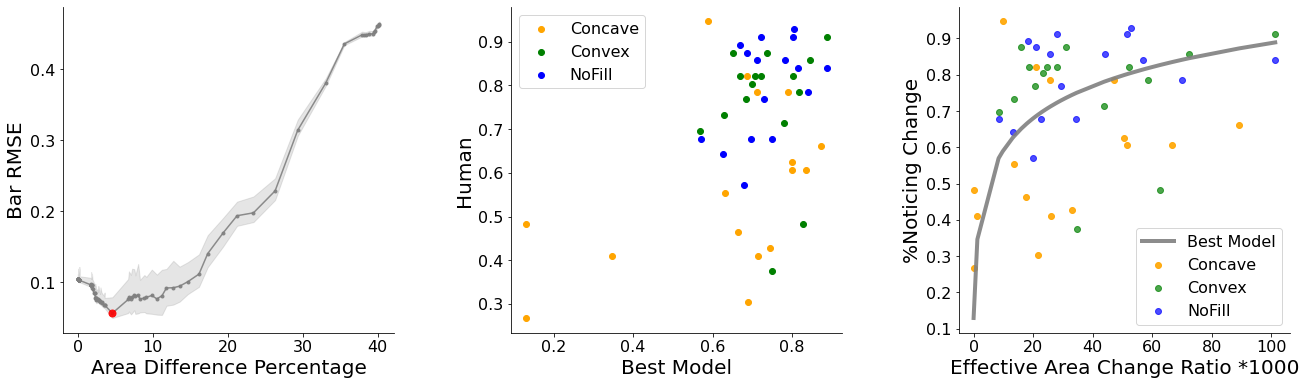

In [29]:
# Logarithm function, no linear complexity

# Setting parameters
LOWERBOUND = (0, 0) # function parameter bounds, a and b
UPPERBOUND = (0.1, 100) 
MODELTITLE = 'Alpha-Shape'
xaxis = alpha_area_diff_ratio * 100 # area difference percentage
parameterlabel = 'Area Difference Percentage' # order alpha values by ADR
modelrange = range(len(xaxis))
niter = 100 # number of iterations in bootstrap for every model
metric = 'Bar RMSE' # 'Bar RMSE', 'Sqrt Mean Squared Error' , 'Pearson Correlation'
scaling_factor = 1000 # scale raw x values by this factor

# Plotting initialization
TICKFONTSIZE = 16
LABELFONTSIZE = 20
TITLEFONTSIZE = 20
LEGENDFONTSIZE = 16
ANNOTATIONFONTSIZE = 16
_, ax = plt.subplots(1,3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# Initialize fitting estimates storage
performance = np.zeros((niter, len(modelrange))) # performance measure between data vs prediction for each model
alist = np.zeros((niter, len(modelrange))) # mean a parameter for each model
blist = np.zeros((niter, len(modelrange))) # mean b parameter for each model
sample_size = Yall.shape[0] # number of subjects

# Iterate through every alpha-shape model
for k in range(len(modelrange)): 
    imodel = modelrange[k] 
    yanswer = Yall.mean(axis=0) # true human response average, used for calculating RMSE

    print('Alpha-shape model idx', imodel)
    for i in range(niter): # bootstrap multiple fits for every alpha-shape model
        # randomly select subjects with replacement
        subject_idx = np.random.choice(a=sample_size, size=sample_size, replace=True)
        ytmp = np.array([x / sample_size if x != 0 else 0 for x in Yall[subject_idx, :].sum(axis=0)])
        xtmp = X[:, imodel]
        xtmp = scaling_factor * xtmp
        
        # fitting
        parameters, pcov = curve_fit(func_log, xtmp, ytmp, 
                                      bounds=(LOWERBOUND, UPPERBOUND), 
                                      p0=[0.01, 50],
                                      maxfev=10000)
        alist[i, k] = parameters[0]
        blist[i, k] = parameters[1]
        
        # prediction 
        prediction = func_log(xtmp, *parameters)
        
        # performance
        if metric == 'Bar RMSE':
            perf = bar_sqrt_mse(prediction, yanswer)
        else:
            print('Metric not found')
            perf = None
        performance[i, k] = perf

# Find the best alpha-shape model
bestmodeli = np.argmin(performance.mean(axis=0))
print('Best alpha-shape model index', bestmodeli)
print('Best alpha-value', alpha_values[bestmodeli])
print('Best alpha-value\'s average area difference ratio', xaxis[bestmodeli])
print('Best model performance:', performance.mean(axis=0)[bestmodeli])
print('Best model performance CI:', np.percentile(performance, 2.5, axis=0)[bestmodeli], np.percentile(performance, 97.5, axis=0)[bestmodeli])
print('Best parameter ab estimates', alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean())

# The best alpha-shape model's effective area change values
bestx = X[:, min(modelrange) + bestmodeli] * scaling_factor

# Plot performance across all alpha-shape models
ax[0].plot(xaxis, performance.mean(axis=0),
               marker='o', ms=3, ls='-', color='gray', alpha=0.9)
ax[0].plot(xaxis[bestmodeli], performance.mean(axis=0)[bestmodeli],
        marker='o', ms=7, alpha=0.9, color='red')
ax[0].fill_between(xaxis,
                np.percentile(performance, 2.5, axis=0), 
                np.percentile(performance, 97.5, axis=0),
                color='gray', alpha=0.2)
ax[0].set_xlabel(parameterlabel, fontsize=LABELFONTSIZE)
ax[0].set_ylabel(metric, fontsize=LABELFONTSIZE)
ax[0].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')


# Plot the best model's prediction vs real human data
bestprediction = func_log(bestx, *(alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean()))
bestpredictionconcave = [bestprediction[i] for i in concave_idx]
bestpredictionconvex = [bestprediction[i] for i in convex_idx]
bestpredictionnofill = [bestprediction[i] for i in nofill_idx]

Y = Yall.mean(axis=0) # average human data
Yconcave = [Y[i] for i in concave_idx]
Yconvex = [Y[i] for i in convex_idx]
Ynofill = [Y[i] for i in nofill_idx]

ax[1].scatter(x=bestpredictionconcave, y=Yconcave, label='Concave', color='orange')
ax[1].scatter(x=bestpredictionconvex, y=Yconvex, label='Convex', color='green')
ax[1].scatter(x=bestpredictionnofill, y=Ynofill, label='NoFill', color='blue')
ax[1].set_xlabel('Best Model', fontsize=LABELFONTSIZE)
ax[1].set_ylabel('Human', fontsize=LABELFONTSIZE)
ax[1].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[1].legend(loc='upper left', fontsize=LEGENDFONTSIZE)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')


# Plot the best model's curve fit and human data
ax[2].plot(sorted(bestx), 
           [x for _,x in sorted(zip(bestx, bestprediction))], 
           lw=4,  color='gray', alpha=0.9, label='Best Model')
Xconcave = [bestx[i] for i in concave_idx]
Xconvex = [bestx[i] for i in convex_idx]
Xnofill = [bestx[i] for i in nofill_idx]
ax[2].scatter(x=Xconcave, y=Yconcave, label='Concave', color='orange', alpha=0.9)
ax[2].scatter(x=Xconvex, y=Yconvex, label='Convex', color='green', alpha=0.7)
ax[2].scatter(x=Xnofill, y=Ynofill, label='NoFill', color='blue', alpha=0.7)
ax[2].set_xlabel('Effective Area Change Ratio *'+str(scaling_factor), fontsize=LABELFONTSIZE)
ax[2].set_ylabel('%Noticing Change', fontsize=LABELFONTSIZE)
ax[2].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[2].legend(fontsize=LEGENDFONTSIZE)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].yaxis.set_ticks_position('left')
ax[2].xaxis.set_ticks_position('bottom')


## Log Function + Linear Complexity

Alpha-shape model idx 0
Alpha-shape model idx 1
Alpha-shape model idx 2
Alpha-shape model idx 3
Alpha-shape model idx 4
Alpha-shape model idx 5
Alpha-shape model idx 6
Alpha-shape model idx 7
Alpha-shape model idx 8
Alpha-shape model idx 9
Alpha-shape model idx 10
Alpha-shape model idx 11
Alpha-shape model idx 12
Alpha-shape model idx 13
Alpha-shape model idx 14
Alpha-shape model idx 15
Alpha-shape model idx 16
Alpha-shape model idx 17
Alpha-shape model idx 18
Alpha-shape model idx 19
Alpha-shape model idx 20
Alpha-shape model idx 21
Alpha-shape model idx 22
Alpha-shape model idx 23
Alpha-shape model idx 24
Alpha-shape model idx 25
Alpha-shape model idx 26
Alpha-shape model idx 27
Alpha-shape model idx 28
Alpha-shape model idx 29
Alpha-shape model idx 30
Alpha-shape model idx 31
Alpha-shape model idx 32
Alpha-shape model idx 33
Alpha-shape model idx 34
Alpha-shape model idx 35
Alpha-shape model idx 36
Alpha-shape model idx 37
Alpha-shape model idx 38
Alpha-shape model idx 39
Alpha-shap

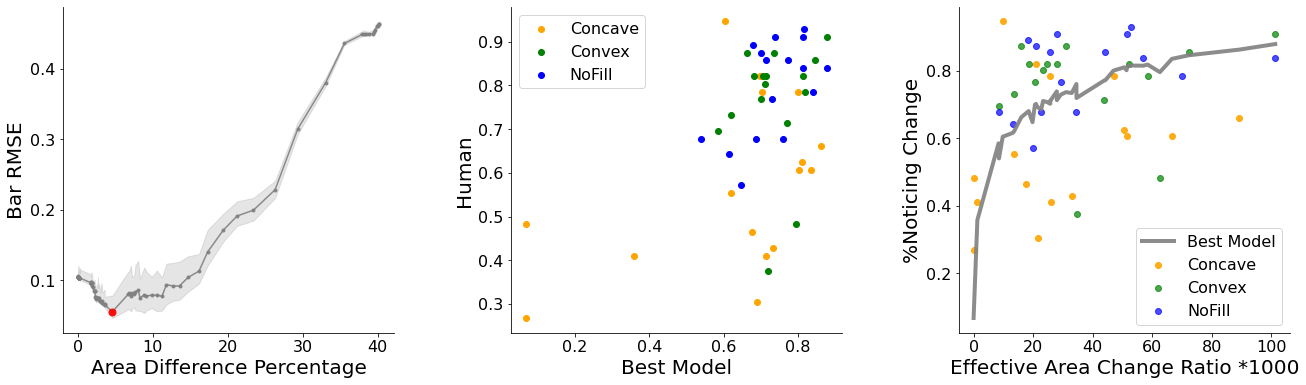

In [42]:
# Setting parameters
LOWERBOUND = (0, 0, 0) # parameter bounds, a b k
UPPERBOUND = (0.1, 100, 0.005)

MODELTITLE = 'Alpha-Shape'
xaxis = alpha_area_diff_ratio * 100
parameterlabel = 'Area Difference Percentage' # order alpha values by ADR
modelrange = range(len(xaxis))
niter = 100 # number of iterations of bootstrap curve fitting in every model
metric = 'Bar RMSE' 
scaling_factor = 1000 # scale x value

# Plotting parameters
TICKFONTSIZE = 16
LABELFONTSIZE = 20
TITLEFONTSIZE = 20
LEGENDFONTSIZE = 16
ANNOTATIONFONTSIZE = 16

_, ax = plt.subplots(1,3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# Initialize performance and parameter storage
performance = np.zeros((niter, len(modelrange))) # performance measure between data vs prediction for each model
alist = np.zeros((niter, len(modelrange))) # mean a parameter for each model
blist = np.zeros((niter, len(modelrange))) # mean b parameter for each model
klist = np.zeros((niter, len(modelrange))) # mean k parameter for each model

sample_size = Yall.shape[0] # number of subjects


# Iterave over every alpha-shape model
for k in range(len(modelrange)):
    imodel = modelrange[k] # model index
    yanswer = Yall.mean(axis=0) # average human response (for calculating RMSE)

    print('Alpha-shape model idx', imodel)
    for i in range(niter): # bootstrap multiple fits in every model
        # randomly select subjects with replacement
        subject_idx = np.random.choice(a=sample_size, size=sample_size, replace=True)
        # prepare x, y data
        ytmp = np.array([x / sample_size if x != 0 else 0 for x in Yall[subject_idx, :].sum(axis=0)])
        xtmp = X[:, imodel] # extract effective area change ratio
        xtmp = scaling_factor * xtmp
        xtmp = np.concatenate((xtmp, numvertices)) # append complexity after effective area change
        
        # fitting
        parameters, pcov = curve_fit(func_complexity_log, xtmp, ytmp, 
                                         bounds=(LOWERBOUND, UPPERBOUND), 
                                         p0=[0.01, 50, 0.001],
                                          maxfev=10000)
        klist[i, k] = parameters[2]
        alist[i, k] = parameters[0]
        blist[i, k] = parameters[1]
        
        # prediction 
        prediction = func_complexity_log(xtmp, *parameters)
        
        # performance
        if metric == 'Bar RMSE':
            perf = bar_sqrt_mse(prediction, yanswer)
        else:
            print('Metric not found')
            perf = None
        performance[i, k] = perf

# Choose the best alpha-shape model
bestmodeli = np.argmin(performance.mean(axis=0))
print('Best model index', bestmodeli)
print('Best alpha-value', alpha_values[bestmodeli])
print('Best xaxis value (ADR)', xaxis[bestmodeli])
print('Best model performance:', performance.mean(axis=0)[bestmodeli])
print('Best model performance CI:', np.percentile(performance, 2.5, axis=0)[bestmodeli], np.percentile(performance, 97.5, axis=0)[bestmodeli])
print('Best model parameter estimates (a,b,k)', alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean(), klist[:, bestmodeli].mean())
# extract effective area change ratio
bestx = X[:, min(modelrange) + bestmodeli] * scaling_factor

# Plot performance across all models
ax[0].plot(xaxis, performance.mean(axis=0),
               marker='o', ms=3, ls='-', color='gray', alpha=0.9)
ax[0].plot(xaxis[bestmodeli], performance.mean(axis=0)[bestmodeli],
        marker='o', ms=7, alpha=0.9, color='red')
ax[0].fill_between(xaxis,
                np.percentile(performance, 2.5, axis=0), 
                np.percentile(performance, 97.5, axis=0),
                color='gray', alpha=0.2)
ax[0].set_xlabel(parameterlabel, fontsize=LABELFONTSIZE)
ax[0].set_ylabel(metric, fontsize=LABELFONTSIZE)
ax[0].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')


# Plot best model prediction vs real human data
bestprediction = func_complexity_log(np.concatenate((bestx, numvertices)), 
                                     *(alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean(), klist[:, bestmodeli].mean()))
bestpredictionconcave = [bestprediction[i] for i in concave_idx]
bestpredictionconvex = [bestprediction[i] for i in convex_idx]
bestpredictionnofill = [bestprediction[i] for i in nofill_idx]
# human data
Y = Yall.mean(axis=0)
Yconcave = [Y[i] for i in concave_idx]
Yconvex = [Y[i] for i in convex_idx]
Ynofill = [Y[i] for i in nofill_idx]
# plotting
ax[1].scatter(x=bestpredictionconcave, y=Yconcave, label='Concave', color='orange')
ax[1].scatter(x=bestpredictionconvex, y=Yconvex, label='Convex', color='green')
ax[1].scatter(x=bestpredictionnofill, y=Ynofill, label='NoFill', color='blue')
ax[1].set_xlabel('Best Model', fontsize=LABELFONTSIZE)
ax[1].set_ylabel('Human', fontsize=LABELFONTSIZE)
ax[1].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[1].legend(loc='upper left', fontsize=LEGENDFONTSIZE)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')


# Plot best model curve fit and real human data
ax[2].plot(sorted(bestx), 
           [x for _,x in sorted(zip(bestx, bestprediction))], 
           lw=4,  color='gray', alpha=0.9, label='Best Model')
Xconcave = [bestx[i] for i in concave_idx]
Xconvex = [bestx[i] for i in convex_idx]
Xnofill = [bestx[i] for i in nofill_idx]
ax[2].scatter(x=Xconcave, y=Yconcave, label='Concave', color='orange', alpha=0.9)
ax[2].scatter(x=Xconvex, y=Yconvex, label='Convex', color='green', alpha=0.7)
ax[2].scatter(x=Xnofill, y=Ynofill, label='NoFill', color='blue', alpha=0.7)
ax[2].set_xlabel('Effective Area Change Ratio *'+str(scaling_factor), fontsize=LABELFONTSIZE)
ax[2].set_ylabel('%Noticing Change', fontsize=LABELFONTSIZE)
ax[2].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[2].legend(fontsize=LEGENDFONTSIZE)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].yaxis.set_ticks_position('left')
ax[2].xaxis.set_ticks_position('bottom')

## Inverse Exponential Decay Function + Linear Complexity

Alpha-shape model idx 0
Alpha-shape model idx 1
Alpha-shape model idx 2
Alpha-shape model idx 3
Alpha-shape model idx 4
Alpha-shape model idx 5
Alpha-shape model idx 6
Alpha-shape model idx 7
Alpha-shape model idx 8
Alpha-shape model idx 9
Alpha-shape model idx 10
Alpha-shape model idx 11
Alpha-shape model idx 12
Alpha-shape model idx 13
Alpha-shape model idx 14
Alpha-shape model idx 15
Alpha-shape model idx 16
Alpha-shape model idx 17
Alpha-shape model idx 18
Alpha-shape model idx 19
Alpha-shape model idx 20
Alpha-shape model idx 21
Alpha-shape model idx 22
Alpha-shape model idx 23
Alpha-shape model idx 24
Alpha-shape model idx 25
Alpha-shape model idx 26
Alpha-shape model idx 27
Alpha-shape model idx 28
Alpha-shape model idx 29
Alpha-shape model idx 30
Alpha-shape model idx 31
Alpha-shape model idx 32
Alpha-shape model idx 33
Alpha-shape model idx 34
Alpha-shape model idx 35
Alpha-shape model idx 36
Alpha-shape model idx 37
Alpha-shape model idx 38
Alpha-shape model idx 39
Alpha-shap

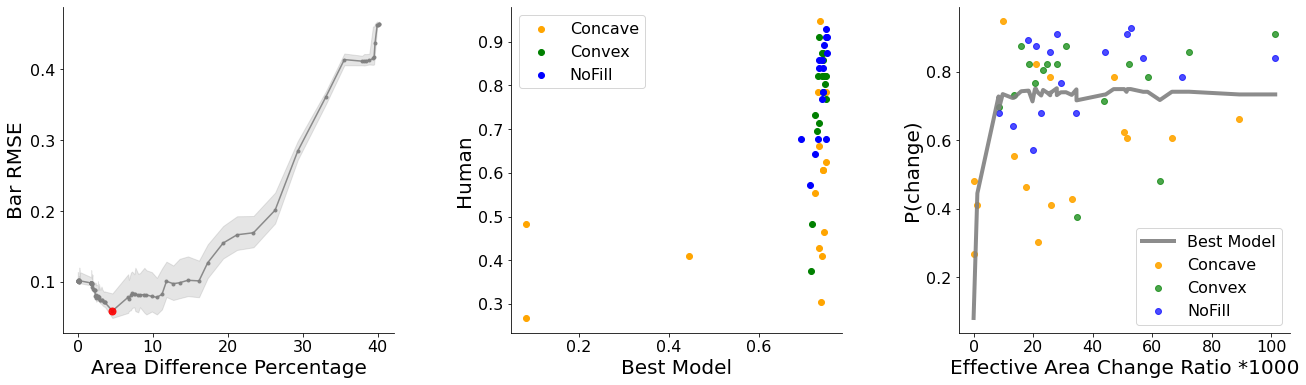

In [43]:
# Initialize parameters
LOWERBOUND = (0, 50, 5, 0) # bounds for the function, (a, b, c, k) 
UPPERBOUND = (0.8, 200, 50, 0.005)
MODELTITLE = 'Alpha Shape'
xaxis = alpha_area_diff_ratio * 100
parameterlabel = 'Area Difference Percentage' # order alpha values by ADR
modelrange = range(len(xaxis))
niter = 100 # number of iterations in bootstrap for every model
metric = 'Bar RMSE' 
scaling_factor = 1000 # scale x values 

# Initialize plotting parameters
TICKFONTSIZE = 16
LABELFONTSIZE = 20
TITLEFONTSIZE = 20
LEGENDFONTSIZE = 16
ANNOTATIONFONTSIZE = 16

_, ax = plt.subplots(1,3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)

# Initialize performance and parameter estimates storage
performance = np.zeros((niter, len(modelrange))) # performance measure between data vs prediction for each model
alist = np.zeros((niter, len(modelrange))) # mean a parameter for each model
blist = np.zeros((niter, len(modelrange))) # mean b parameter for each model
clist = np.zeros((niter, len(modelrange))) # mean c parameter for each model
klist = np.zeros((niter, len(modelrange))) # mean k parameter for each model

sample_size = Yall.shape[0] # number of subjects


# Iterate over every alpha-shape model
for k in range(len(modelrange)):
    imodel = modelrange[k] 
    yanswer = Yall.mean(axis=0) # average human response (for calculating RMSE)

    print('Alpha-shape model idx', imodel)
    for i in range(niter): # bootstrap multiple curve fits in every model
        # randomly select subjects with replacement
        subject_idx = np.random.choice(a=sample_size, size=sample_size, replace=True)
        # average human responses from the bootstrapped sample
        ytmp = np.array([x / sample_size if x != 0 else 0 for x in Yall[subject_idx, :].sum(axis=0)])
        # extract effective area change ratio
        xtmp = X[:, imodel]
        xtmp = scaling_factor * xtmp
        xtmp = np.concatenate((xtmp, numvertices)) # append complexity after effective area change ratio
        
        # fitting
        parameters, pcov = curve_fit(func_complexity_exp, xtmp, ytmp, 
                                          bounds=(LOWERBOUND, UPPERBOUND), 
                                         p0=[0.8, 50, 20, 0.001],
                                          maxfev=10000)
        alist[i, k] = parameters[0]
        blist[i, k] = parameters[1]
        clist[i, k] = parameters[2]
        klist[i, k] = parameters[3]
        
        # prediction 
        prediction = func_complexity_exp(xtmp, *parameters)
        
        # performance
        if metric == 'Bar RMSE':
            perf = bar_sqrt_mse(prediction, yanswer)
        else:
            print('Metric not found')
            perf = None
        performance[i, k] = perf

# Choose the best model
bestmodeli = np.argmin(performance.mean(axis=0))
print('Best model index', bestmodeli)
print('Best alpha', alpha_values[bestmodeli])
print('Best alpha-value\'s area difference ratio', xaxis[bestmodeli])
print('Best model performance:', performance.mean(axis=0)[bestmodeli])
print('Best model performance CI:', np.percentile(performance, 2.5, axis=0)[bestmodeli], np.percentile(performance, 97.5, axis=0)[bestmodeli])
print('Best model parameter estimates (a, b, c, k)', alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean(), clist[:, bestmodeli].mean(), klist[:, bestmodeli].mean())

# best models' effective area change ratio
bestx = X[:, min(modelrange) + bestmodeli] * scaling_factor

# Plot performance across all models
ax[0].plot(xaxis, performance.mean(axis=0),
               marker='o', ms=3, ls='-', color='gray', alpha=0.9)
ax[0].plot(xaxis[bestmodeli], performance.mean(axis=0)[bestmodeli],
        marker='o', ms=7, alpha=0.9, color='red')
ax[0].fill_between(xaxis,
                np.percentile(performance, 2.5, axis=0), 
                np.percentile(performance, 97.5, axis=0),
                color='gray', alpha=0.2)
ax[0].set_xlabel(parameterlabel, fontsize=LABELFONTSIZE)
ax[0].set_ylabel(metric, fontsize=LABELFONTSIZE)
ax[0].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].yaxis.set_ticks_position('left')
ax[0].xaxis.set_ticks_position('bottom')


# Plot best model's prediction vs human data
bestprediction = func_complexity_exp(np.concatenate((bestx, numvertices)), 
                                     *(alist[:, bestmodeli].mean(), blist[:, bestmodeli].mean(), clist[:, bestmodeli].mean(), klist[:, bestmodeli].mean()))
bestpredictionconcave = [bestprediction[i] for i in concave_idx]
bestpredictionconvex = [bestprediction[i] for i in convex_idx]
bestpredictionnofill = [bestprediction[i] for i in nofill_idx]
# human data
Y = Yall.mean(axis=0)
Yconcave = [Y[i] for i in concave_idx]
Yconvex = [Y[i] for i in convex_idx]
Ynofill = [Y[i] for i in nofill_idx]
# plot
ax[1].scatter(x=bestpredictionconcave, y=Yconcave, label='Concave', color='orange')
ax[1].scatter(x=bestpredictionconvex, y=Yconvex, label='Convex', color='green')
ax[1].scatter(x=bestpredictionnofill, y=Ynofill, label='NoFill', color='blue')
ax[1].set_xlabel('Best Model', fontsize=LABELFONTSIZE)
ax[1].set_ylabel('Human', fontsize=LABELFONTSIZE)
ax[1].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[1].legend(loc='upper left', fontsize=LEGENDFONTSIZE)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')


# Plot best model's curve fit and human data
ax[2].plot(sorted(bestx), 
           [x for _,x in sorted(zip(bestx, bestprediction))], 
           lw=4,  color='gray', alpha=0.9, label='Best Model')
Xconcave = [bestx[i] for i in concave_idx]
Xconvex = [bestx[i] for i in convex_idx]
Xnofill = [bestx[i] for i in nofill_idx]
ax[2].scatter(x=Xconcave, y=Yconcave, label='Concave', color='orange', alpha=0.9)
ax[2].scatter(x=Xconvex, y=Yconvex, label='Convex', color='green', alpha=0.7)
ax[2].scatter(x=Xnofill, y=Ynofill, label='NoFill', color='blue', alpha=0.7)
ax[2].set_xlabel('Effective Area Change Ratio *'+str(scaling_factor), fontsize=LABELFONTSIZE)
ax[2].set_ylabel('P(change)', fontsize=LABELFONTSIZE)
ax[2].tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax[2].legend(fontsize=LEGENDFONTSIZE)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].yaxis.set_ticks_position('left')
ax[2].xaxis.set_ticks_position('bottom')

## Plot Performance across Models

Need to run one of the functional forms above (among three) and plot its results.

In [44]:
def smoothing2(values, window=5): 
  # non-overlapping rolling mean smoothing method
  return values.reshape(-1, window).mean(axis=1)

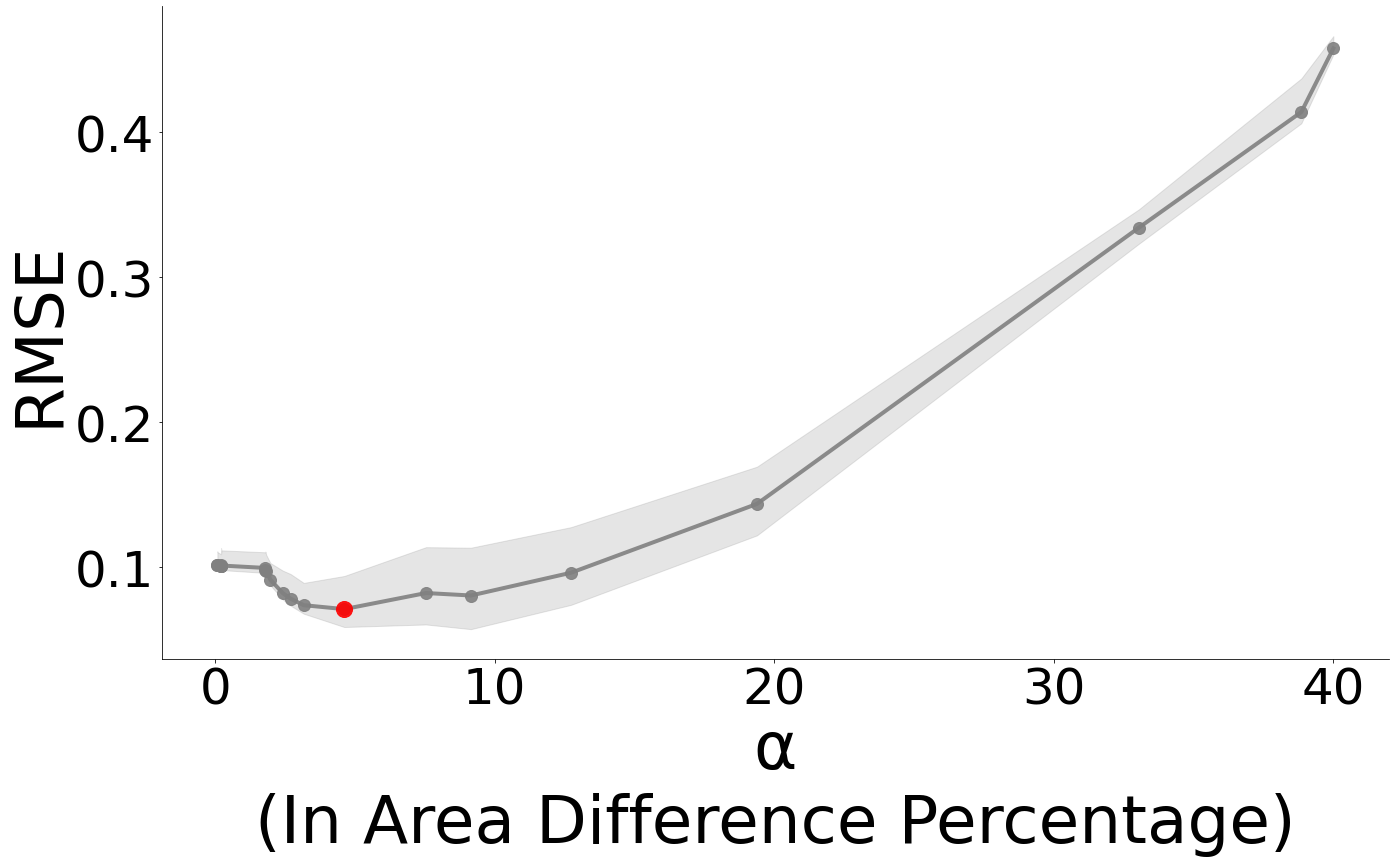

In [45]:
_, ax = plt.subplots(1,1, figsize=(22, 12))
LABELFONTSIZE = 64
TICKFONTSIZE = 50

# performance across all models
performance_smoothed = smoothing2(performance.mean(axis=0))
xaxis_smoothed = xaxis.reshape(-1, performance.shape[1] // len(performance_smoothed))[:, (performance.shape[1] // len(performance_smoothed))//2]
CIup_smoothed = smoothing2(np.percentile(performance, 97.5, axis=0))
CIlow_smoothed = smoothing2(np.percentile(performance, 2.5, axis=0))

ax.plot(xaxis_smoothed, performance_smoothed,
            marker='o', ls='-', lw=4, ms=12, alpha=0.9, color='gray')
besti_smoothed = np.argmin(performance_smoothed)
if metric=="Pearson Correlation":
  besti_smoothed = np.argmax(performance_smoothed)
ax.plot(xaxis_smoothed[besti_smoothed], performance_smoothed[besti_smoothed],
        marker='o', ms=16, alpha=0.9, color='red')
ax.fill_between(xaxis_smoothed,
                CIlow_smoothed, 
                CIup_smoothed,
                color='gray', alpha=0.2)
ax.set_xlabel('\u03B1\n(In Area Difference Percentage)', fontsize=LABELFONTSIZE+2)
ax.set_ylabel('RMSE', fontsize=LABELFONTSIZE+2) # ylabel 'Bar RMSE' was changed to 'RMSE' manually, but still used Bar_RMSE metric function
ax.tick_params(axis="both", labelsize=TICKFONTSIZE) 
ax.spines['right'].set_visible(False) # remove top and right border
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## Plot the Best Model

Need to run one of the functional forms above (among three) and plot its results.

In [46]:
# Load human data
data3a = pd.read_csv('exp3a_data.csv')

data3a["condition"] = data3a["shape"] + "_" + data3a["changeType"]

data3a["response"].replace(to_replace="same", value=0, inplace=True)
data3a["response"].replace(to_replace="different", value=1, inplace=True)

data3a = data3a[data3a["condition"].str.contains("catch")==False]
datanochange = data3a[data3a["condition"].str.contains("no_change")==True]
data3a = data3a[data3a["condition"].str.contains("no_change")==False]

df3a = pd.DataFrame(data3a.groupby(["condition"])["response"].mean()).reset_index()

concave3a = df3a[df3a['condition'].str.contains("concave_area")==True]["response"].to_numpy() * 100
convex3a = df3a[df3a['condition'].str.contains("convex_area")==True]["response"].to_numpy() * 100
nofill3a = df3a[df3a['condition'].str.contains("concave_nofill_area")==True]["response"].to_numpy() * 100

Paired t-test concave vs convex Ttest_relResult(statistic=-1.7697640680091027, pvalue=0.09708525619158766)
Paired t-test concave vs nofill Ttest_relResult(statistic=-1.800057992995928, pvalue=0.0919925991419683)
Paired t-test nofill vs convex Ttest_relResult(statistic=0.07112248954615907, pvalue=0.9442398755399752)


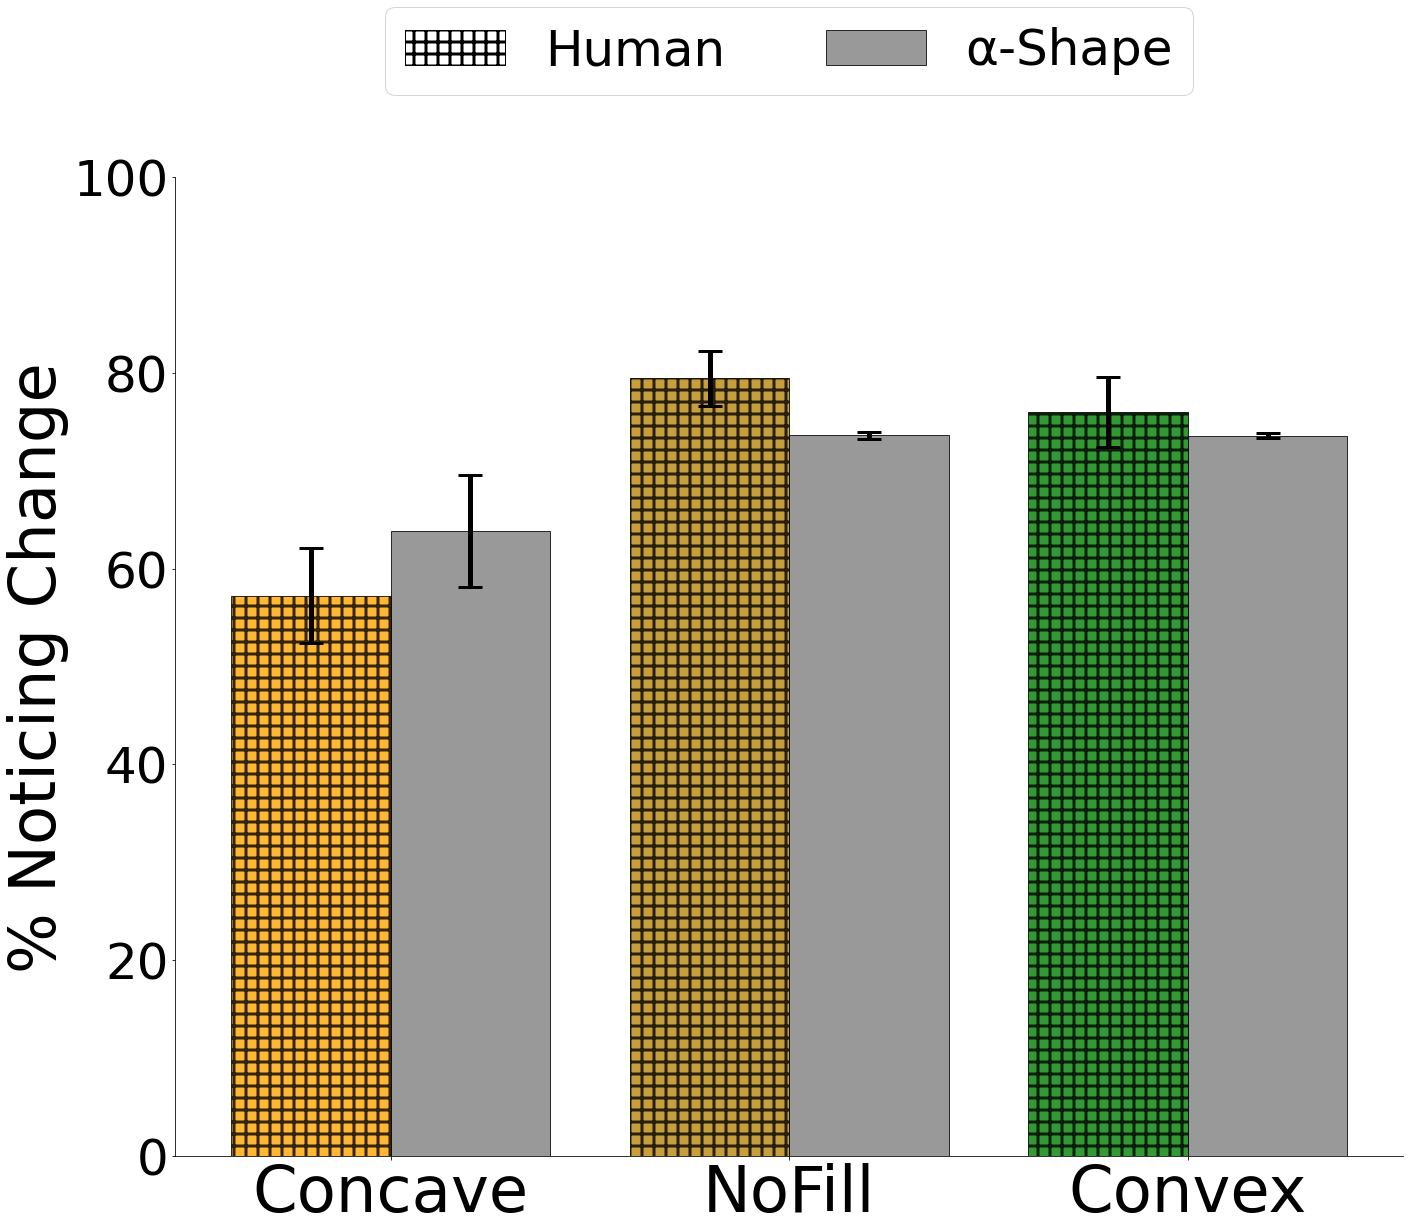

In [47]:
_, ax = plt.subplots(1,1, figsize=(22, 18))
LABELFONT = 64
TICKFONT = 50
LEGENDFONT = 50

ax.bar(0-0.2, concave3a.mean(), 0.4, 
       yerr = [stats.sem(concave3a)],
       error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='orange', edgecolor='k', hatch='+',
       label='Concave')
ax.bar(1-0.2, nofill3a.mean(), 0.4,
       yerr = [stats.sem(nofill3a)],
       error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='darkgoldenrod', edgecolor='k', hatch='+',
       label='NoFill')
ax.bar(2-0.2, convex3a.mean(), 0.4, 
       yerr = [stats.sem(convex3a)],
       error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='green', edgecolor='k', hatch='+',
       label='Convex')

plt.rcParams['hatch.linewidth'] = 3
ax.bar(0+0.2,
        np.mean(bestpredictionconcave)*100,
        0.4,
        yerr=[stats.sem(np.array(bestpredictionconcave)*100)],
        error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='gray', edgecolor='k')
ax.bar(1+0.2,
        [np.mean(bestpredictionnofill)*100],
        0.4,
        yerr=[stats.sem(np.array(bestpredictionnofill)*100)],
        error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='gray', edgecolor='k')
ax.bar(2+0.2,
        [np.mean(bestpredictionconvex)*100],
        0.4,
        yerr=[stats.sem(np.array(bestpredictionconvex)*100)],
        error_kw=dict(lw=5, capsize=12, capthick=3),
       alpha=0.8, color='gray', edgecolor='k', 
        label='\u03B1-Shape')

plt.ylim(0,100)
plt.xticks(ticks=np.arange(3), labels=['Concave', 'NoFill', 'Convex'], fontsize=LABELFONT)
plt.xlabel('')
plt.ylabel('% Noticing Change', fontsize=LABELFONT)
plt.yticks(fontsize=TICKFONT)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# make legend
legend_elements = [Patch(facecolor='white', edgecolor='black', label='Human', hatch='+'),
                   Patch(facecolor='gray', alpha=0.8, edgecolor='black', label='\u03B1-Shape')]
leg1 = plt.legend(handles=legend_elements[:3], ncol=3, loc="upper center", fontsize=LEGENDFONT, bbox_to_anchor=(0.5, 1.2))
leg1._legend_box.stale = True

print('Paired t-test concave vs convex', stats.ttest_rel(bestpredictionconcave, bestpredictionconvex)) 
print('Paired t-test concave vs nofill', stats.ttest_rel(bestpredictionconcave, bestpredictionnofill))
print('Paired t-test nofill vs convex', stats.ttest_rel(bestpredictionnofill, bestpredictionconvex))